In [1]:
import pandas as pd, geopandas as gpd, numpy as np, matplotlib.pyplot as plt
from os.path import join

pd.set_option('display.max_columns', 50)
plt.rcParams['pdf.fonttype'] = 'truetype'

## helpers

In [2]:
def decorate(xl, yl):
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.box(None)
    plt.legend(bbox_to_anchor=(1,.5), loc='center left', frameon=False)

## load data

In [3]:
turn = pd.read_csv(r"M:\NYSERDA_Ignition Grant 19041\03_GIS+ANALYSIS\01_DATA\station_vol_by_hour_200818.csv")

In [4]:
turn.shape

(71836, 7)

In [5]:
turn.sample(10)

,station_id,GTFS Latitude,GTFS Longitude,wkdaynbr,timegroupstr,date,entries_diff
18396,Houston StBroadway - 7Av,40.728251,-74.005367,3,4pm - 8pm,08/05/2020,963.0
7558,51 StLexington Av,40.757107,-73.971920,2,8pm - 12am,07/24/2018,2079.0
21584,Beach 36 StRockaway,40.595398,-73.768175,3,8am - 12pm,07/25/2018,804.0
33849,3 Av - 149 StLenox - White Plains Rd,40.816109,-73.917757,0,4am - 8am,07/26/2020,423.0
19081,Clinton - Washington AvsCrosstown,40.688089,-73.966839,1,4pm - 8pm,07/30/2018,923.0
27285,Seneca AvMyrtle Av,40.702762,-73.907740,1,12pm - 4pm,07/30/2018,591.0
2314,Jamaica - 179 StQueens Blvd,40.712646,-73.783817,4,4am - 8am,08/02/2018,4140.0
52971,Broadway-Lafayette St6th Av - Culver,40.725297,-73.996204,4,8am - 12pm,08/06/2020,131.0
25092,86 St4th Av,40.622687,-74.028398,3,8pm - 12am,08/01/2018,666.0
19332,125 StBroadway - 7Av,40.815581,-73.958372,6,8am - 12pm,07/25/2020,911.0


## prep data

In [6]:
# Datetime format for sorting / time-series analysis
turn['dt'] = pd.to_datetime(turn.date)

In [7]:
# recode time group as int for sorting / time-series analysis

time_map = {
    '8pm - 12am':5,
    '12pm - 4pm':3,
    '4pm - 8pm':4,
    '8am - 12pm':2,
    '4am - 8am':1,
    '12am - 4am':0}

turn['timegroupnbr'] = turn.timegroupstr.map(time_map)

assert turn.timegroupnbr.isna().sum() == 0

## filter and dissagregate

In [8]:
stops = [
    'Jamaica Center - Parsons/ArcherQueens - Archer',
    'Sutphin Blvd - Archer Av - JFK AirportQueens - Archer',
    'Sutphin BlvdQueens Blvd']

In [9]:
turn.station_id.isin(stops).sum()

498

In [10]:
(~turn.wkdaynbr.isin([5, 6])).sum()

51930

In [11]:
(turn.station_id.isin(stops) & ~turn.wkdaynbr.isin([5, 6]) & turn.dt.dt.year.eq(2018)).sum()

180

In [12]:
turn.dt.dt.year.value_counts()

2020    36372
2018    35464
Name: dt, dtype: int64

In [13]:
filt = turn.station_id.isin(stops) & ~turn.wkdaynbr.isin([5, 6])

group_cols = ['station_id', 'dt', 'timegroupnbr']
agg = {'entries_diff':'sum'}

df18 = turn[filt & turn.dt.dt.year.eq(2018)]\
    .groupby(group_cols).agg(agg).reset_index()
df20 = turn[filt & turn.dt.dt.year.eq(2020)]\
    .groupby(group_cols).agg(agg).reset_index()

df18.sample(5)

,station_id,dt,timegroupnbr,entries_diff
4,Jamaica Center - Parsons/ArcherQueens - Archer,2018-07-22,4,2686.0
57,Jamaica Center - Parsons/ArcherQueens - Archer,2018-08-02,3,3060.0
80,Sutphin Blvd - Archer Av - JFK AirportQueens -...,2018-07-25,2,1476.0
172,Sutphin BlvdQueens Blvd,2018-08-01,4,5327.0
18,Jamaica Center - Parsons/ArcherQueens - Archer,2018-07-25,0,471.0


In [14]:
df20.sample(10)

,station_id,dt,timegroupnbr,entries_diff
6,Jamaica Center - Parsons/ArcherQueens - Archer,2020-07-27,0,44.0
163,Sutphin BlvdQueens Blvd,2020-08-04,1,1919.0
16,Jamaica Center - Parsons/ArcherQueens - Archer,2020-07-28,4,1860.0
22,Jamaica Center - Parsons/ArcherQueens - Archer,2020-07-29,4,1983.0
108,Sutphin Blvd - Archer Av - JFK AirportQueens -...,2020-08-05,0,48.0
15,Jamaica Center - Parsons/ArcherQueens - Archer,2020-07-28,3,1833.0
67,Sutphin Blvd - Archer Av - JFK AirportQueens -...,2020-07-27,1,13.0
175,Sutphin BlvdQueens Blvd,2020-08-06,1,2026.0
134,Sutphin BlvdQueens Blvd,2020-07-28,2,1342.0
91,Sutphin Blvd - Archer Av - JFK AirportQueens -...,2020-08-02,1,3.0


## ridership trend

### overall

In [15]:
f'Ridership is down {np.round((1 - df20.entries_diff.sum() / df18.entries_diff.sum()) * 100, 1)}% overall'

'Ridership is down 57.7% overall'

In [16]:
1 - \
df20.groupby('station_id').agg({'entries_diff':'sum'}).div(
    df18.groupby('station_id').agg({'entries_diff':'sum'}))\
    .round(2)

,entries_diff
station_id,
Jamaica Center - Parsons/ArcherQueens - Archer,0.36
Sutphin Blvd - Archer Av - JFK AirportQueens - Archer,0.65
Sutphin BlvdQueens Blvd,0.72


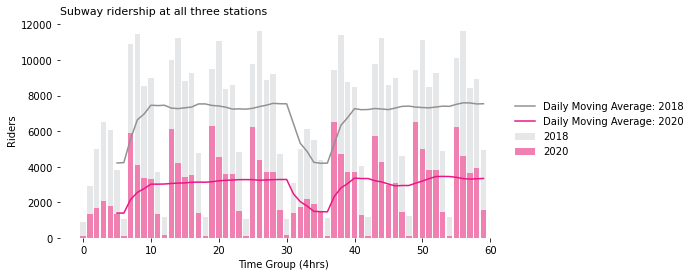

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'all three stations'

a19 = df18.groupby(['dt', 'timegroupnbr']).agg({'entries_diff':'sum'}).reset_index().entries_diff
a20 = df20.groupby(['dt', 'timegroupnbr']).agg({'entries_diff':'sum'}).reset_index().entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2018')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2018')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway ridership at {station}', loc='left', fontsize=11)

plt.show();

### sutphin blvd - queens blvd

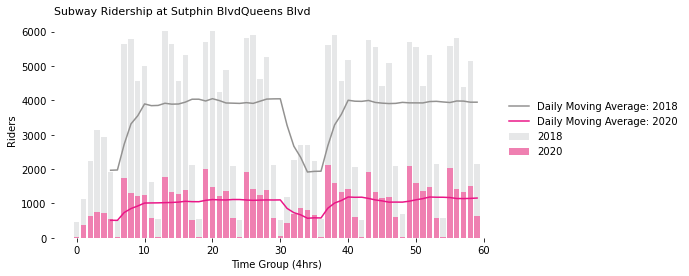

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'Sutphin BlvdQueens Blvd'

a19 = df18[df18.station_id.eq(station)].reset_index(drop=True).entries_diff
a20 = df20[df20.station_id.eq(station)].reset_index(drop=True).entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2018')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2018')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway Ridership at {station}', loc='left', fontsize=11)

plt.show();

### sutphin blvd - archer av - jfk - archer

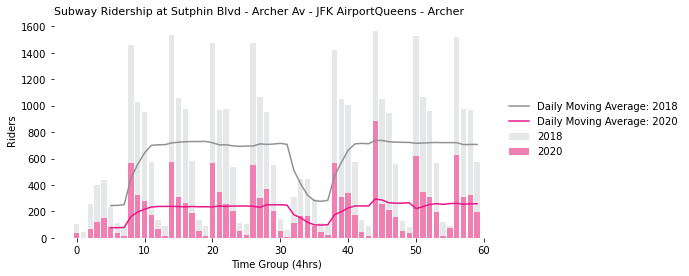

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'Sutphin Blvd - Archer Av - JFK AirportQueens - Archer'

a19 = df18[df18.station_id.eq(station)].reset_index(drop=True).entries_diff
a20 = df20[df20.station_id.eq(station)].reset_index(drop=True).entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2018')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2018')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway Ridership at {station}', loc='left', fontsize=11)

plt.show();

### jamaica center

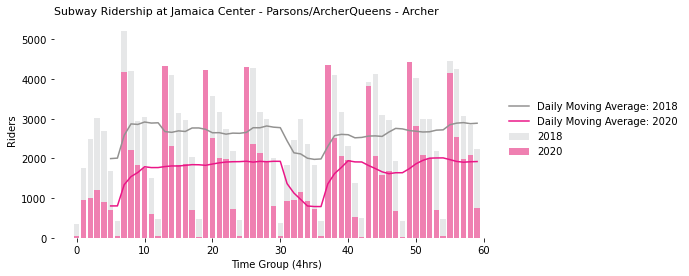

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'Jamaica Center - Parsons/ArcherQueens - Archer'

a19 = df18[df18.station_id.eq(station)].reset_index(drop=True).entries_diff
a20 = df20[df20.station_id.eq(station)].reset_index(drop=True).entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2018')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2018')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway Ridership at {station}', loc='left', fontsize=11)

plt.show();

## change in entries by time group

### overall

In [21]:
a19 = df18.copy()
a19.columns = [c + '_19' for c in a19.columns]

a20 = df20.copy()
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx.round(2)

entries_share                   
                          min   max median  mean
timegroupnbr_19                                 
0                        0.03  0.48   0.10  0.17
1                        0.04  1.20   0.36  0.51
2                        0.23  0.70   0.39  0.40
3                        0.24  0.70   0.32  0.39
4                        0.22  0.85   0.33  0.40
5                        0.24  0.43   0.33  0.33

In [22]:
(1 - xx).round(2)

entries_share                   
                          min   max median  mean
timegroupnbr_19                                 
0                        0.97  0.52   0.90  0.83
1                        0.96 -0.20   0.64  0.49
2                        0.77  0.30   0.61  0.60
3                        0.76  0.30   0.68  0.61
4                        0.78  0.15   0.67  0.60
5                        0.76  0.57   0.67  0.67

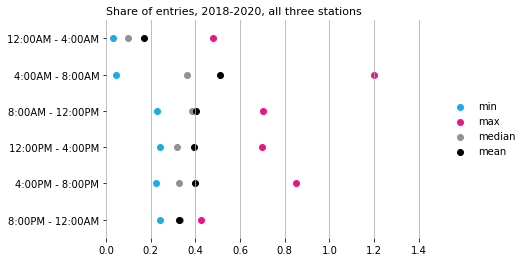

In [23]:
# fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2018-2020, all three stations', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.xlim(0,1.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

### sutphin blvd - queens blvd

In [24]:
station = 'Sutphin BlvdQueens Blvd'

a19 = df18[df18.station_id.eq(station)].copy().reset_index(drop=True)
a20 = df20[df20.station_id.eq(station)].copy().reset_index(drop=True)

a19.columns = [c + '_19' for c in a19.columns]
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx.round(2)

entries_share                   
                          min   max median  mean
timegroupnbr_19                                 
0                        0.03  0.08   0.05  0.05
1                        0.30  0.38   0.34  0.34
2                        0.23  0.30   0.24  0.26
3                        0.24  0.32   0.28  0.28
4                        0.23  0.29   0.27  0.27
5                        0.24  0.36   0.29  0.29

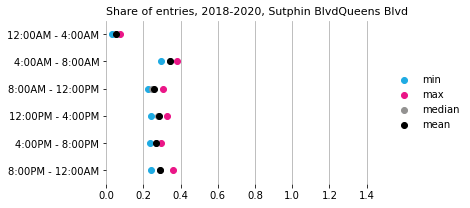

In [25]:
fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2018-2020, {station}', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.xlim(0, 1.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

### sutphin blvd - archer av - jfk - archer

In [26]:
station = 'Sutphin Blvd - Archer Av - JFK AirportQueens - Archer'

a19 = df18[df18.station_id.eq(station)].copy().reset_index(drop=True)
a20 = df20[df20.station_id.eq(station)].copy().reset_index(drop=True)

a19.columns = [c + '_19' for c in a19.columns]
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx.round(2)

entries_share                   
                          min   max median  mean
timegroupnbr_19                                 
0                        0.13  0.48   0.38  0.36
1                        0.04  0.83   0.17  0.24
2                        0.28  0.57   0.39  0.40
3                        0.24  0.38   0.31  0.31
4                        0.22  0.39   0.33  0.31
5                        0.28  0.39   0.33  0.33

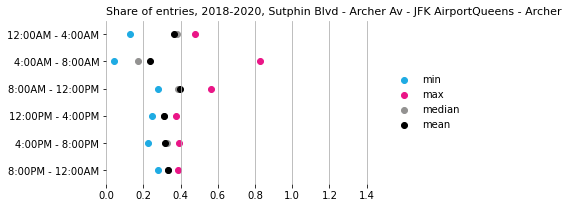

In [27]:
fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2018-2020, {station}', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.xlim(0, 1.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

### jamaica center

In [28]:
station = 'Jamaica Center - Parsons/ArcherQueens - Archer'

a19 = df18[df18.station_id.eq(station)].copy().reset_index(drop=True)
a20 = df20[df20.station_id.eq(station)].copy().reset_index(drop=True)

a19.columns = [c + '_19' for c in a19.columns]
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx.round(2)

entries_share                   
                          min   max median  mean
timegroupnbr_19                                 
0                        0.05  0.12   0.10  0.09
1                        0.50  1.20   1.04  0.95
2                        0.39  0.70   0.56  0.56
3                        0.38  0.70   0.63  0.58
4                        0.33  0.85   0.63  0.61
5                        0.32  0.43   0.37  0.37

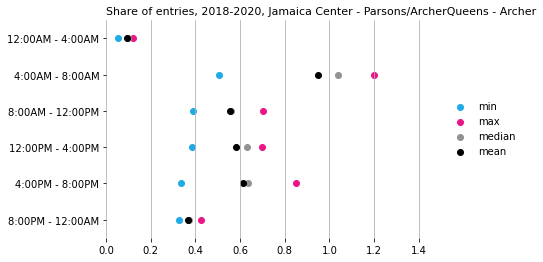

In [29]:
# fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2018-2020, {station}', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.xlim(0, 1.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

## takeaways

*NOTE: The previous analysis compared 2019 to 2020 data. Here, we compare 2018 to 2020 data. Overall subway ridership in 2018 was slightly higher than in 2019. The numbers below may reflect this discrepancy in data sources.*

The data suggest three major takeaways:
1. Overall ridership across the three stations is way down, at **about 58% of 2018's ridership.** Compare to 56% a month ago.
    1. 36% at Jamaica Center. Compare to 31% a month ago.
    2. 72% at Sutphin Blvd / Queens Blvd. Compare to 72% a month ago.
    3. 65% at Sutphin Blvd / Archer Ave. Compare to 68% a month ago.
    
    
2. In the two week period of study in 2020, the **overall trend in ridership is flat at all three stations** with no signs of a recent increase. Same as a month ago.


3. While overall ridership is down, **ridership during the early morning peak (4AM - 8AM) has decreased less, about 49% on average compared to an overall decline of 58%.** One hypothesis for this is that ridership among essential workers (who might need to get up early) is slightly more robust.
    1. However, compared to last month, this number has gone up about eight percentage points. More essential workers may be out of work.
    2. At all three stops the number of riders during the morning peak has decreased compared to 2018.